<a href="https://colab.research.google.com/github/praveenmaloth/scenario-1-landcover-classification/blob/main/earth_observation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import os
from pathlib import Path
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from shapely.geometry import box, Point
from pyproj import Transformer
import geemap

# Change this if you put the folder elsewhere in Drive
BASE = Path("/content/drive/MyDrive/earth-observation-iitgn-2025")
DATA_DIR = BASE / "data"
RGB_DIR = DATA_DIR / "rgb"
OUTPUTS = BASE / "outputs"
OUTPUTS.mkdir(parents=True, exist_ok=True)

print("DATA_DIR:", DATA_DIR)
print("RGB_DIR exists:", RGB_DIR.exists())
print("Output folder:", OUTPUTS)


DATA_DIR: /content/drive/MyDrive/earth-observation-iitgn-2025/data
RGB_DIR exists: True
Output folder: /content/drive/MyDrive/earth-observation-iitgn-2025/outputs


In [ ]:
# load
ncr_fp = str(DATA_DIR / "delhi_ncr_region.geojson")
ncr = gpd.read_file(ncr_fp)
print("Original CRS:", ncr.crs)
# project to EPSG:32644 (UTM zone 44N) for meter-based grid creation
ncr_utm = ncr.to_crs(32644)
print("Reprojected CRS:", ncr_utm.crs)


Original CRS: EPSG:4326
Reprojected CRS: EPSG:32644


In [ ]:
minx, miny, maxx, maxy = ncr_utm.total_bounds
grid_size = 60000  # 60 km in meters

grid_cells = []
x = minx
while x < maxx:
    y = miny
    while y < maxy:
        grid_cells.append(box(x, y, x + grid_size, y + grid_size))
        y += grid_size
    x += grid_size

grid = gpd.GeoDataFrame(geometry=grid_cells, crs=32644)
# keep only cells that intersect NCR (optional - speeds up later)
grid = grid[grid.intersects(ncr_utm.unary_union)].reset_index(drop=True)
print("Total grid cells intersecting NCR:", len(grid))


Total grid cells intersecting NCR: 29


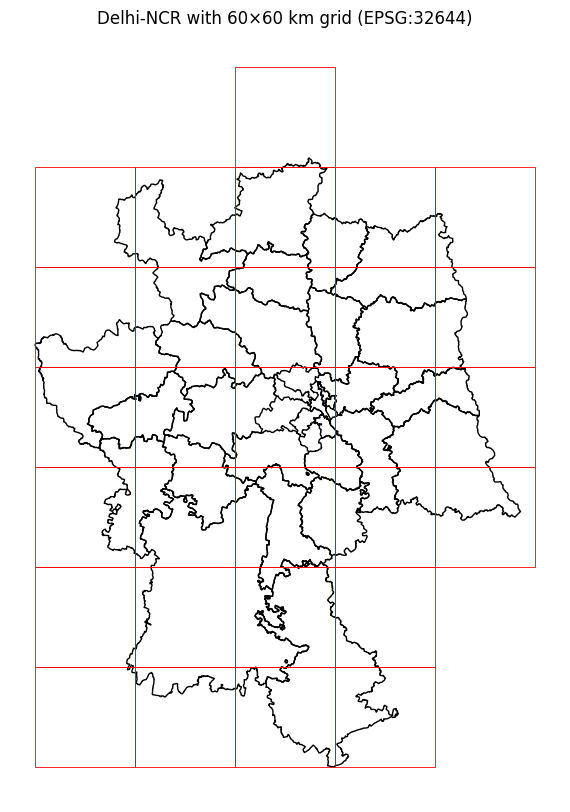

Saved: /content/drive/MyDrive/earth-observation-iitgn-2025/outputs/ncr_grid_plot.png


In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ncr_utm.boundary.plot(ax=ax, linewidth=1, edgecolor="black")
grid.boundary.plot(ax=ax, linewidth=0.6, edgecolor="red")
ax.set_title("Delhi-NCR with 60×60 km grid (EPSG:32644)")
ax.set_axis_off()
plt.savefig(str(OUTPUTS / "ncr_grid_plot.png"), dpi=300, bbox_inches="tight")
plt.show()
print("Saved:", OUTPUTS / "ncr_grid_plot.png")


In [ ]:
from pathlib import Path
BASE = Path("/content/drive/MyDrive/earth-observation-iitgn-2025")
DATA_DIR = BASE / "data"
OUTPUTS = BASE / "outputs"
RGB_DIR = DATA_DIR / "rgb"

print("BASE:", BASE.exists(), BASE)
print("DATA_DIR:", DATA_DIR.exists(), DATA_DIR)
print("RGB_DIR:", RGB_DIR.exists(), RGB_DIR)
print("OUTPUTS:", OUTPUTS.exists(), OUTPUTS)

print("\nList outputs:")
if OUTPUTS.exists():
    for p in sorted(OUTPUTS.iterdir()):
        print(" -", p.name)
else:
    print("Outputs folder does not exist yet.")


BASE: True /content/drive/MyDrive/earth-observation-iitgn-2025
DATA_DIR: True /content/drive/MyDrive/earth-observation-iitgn-2025/data
RGB_DIR: True /content/drive/MyDrive/earth-observation-iitgn-2025/data/rgb
OUTPUTS: True /content/drive/MyDrive/earth-observation-iitgn-2025/outputs

List outputs:
 - best_resnet18.pth
 - class_distribution.png
 - filtered_images.csv
 - grid.geojson
 - grid_corners_centers.geojson
 - interactive_grid_map.html
 - landcover_labeled_dataset.csv
 - ncr_grid_plot.png
 - test_split.csv
 - train_split.csv


In [ ]:
import geopandas as gpd
from shapely.geometry import box, Point
from pathlib import Path
import warnings

warnings.filterwarnings("ignore")

BASE = Path("/content/drive/MyDrive/earth-observation-iitgn-2025")
DATA_DIR = BASE / "data"
OUTPUTS = BASE / "outputs"
OUTPUTS.mkdir(exist_ok=True)

# 1 — Load NCR GeoJSON
ncr_path = DATA_DIR / "delhi_ncr_region.geojson"
assert ncr_path.exists(), f"❌ NCR file not found at {ncr_path}"

print("NCR File Found ✔:", ncr_path)

ncr = gpd.read_file(str(ncr_path))
ncr_utm = ncr.to_crs(32644)

print("CRS After Reprojection:", ncr_utm.crs)

# 2 — Create 60×60 km grid
minx, miny, maxx, maxy = ncr_utm.total_bounds
grid_size = 60000  # meters

grid_cells = []
x = minx
while x < maxx:
    y = miny
    while y < maxy:
        grid_cells.append(box(x, y, x + grid_size, y + grid_size))
        y += grid_size
    x += grid_size

grid = gpd.GeoDataFrame(geometry=grid_cells, crs=32644)
grid = grid[grid.intersects(ncr_utm.unary_union)].reset_index(drop=True)

print("Total Grid Cells:", len(grid))

# 3 — Save GRID GEOJSON
grid_file = OUTPUTS / "grid.geojson"
grid.to_file(str(grid_file), driver="GeoJSON")
print("Saved GRID:", grid_file, "✔")

# 4 — Build corners and centers
corner_rows = []
for idx, cell in enumerate(grid.geometry):
    minx, miny, maxx, maxy = cell.bounds
    cx, cy = cell.centroid.x, cell.centroid.y
    pts = [
        ("SW", Point(minx, miny)),
        ("NW", Point(minx, maxy)),
        ("SE", Point(maxx, miny)),
        ("NE", Point(maxx, maxy)),
        ("CENTER", Point(cx, cy)),
    ]
    for label, pt in pts:
        corner_rows.append({"grid_id": idx, "point_type": label, "geometry": pt})

corners = gpd.GeoDataFrame(corner_rows, crs=32644)

# 5 — Save corners file
corners_file = OUTPUTS / "grid_corners_centers.geojson"
corners.to_file(str(corners_file), driver="GeoJSON")
print("Saved Corners+Centers:", corners_file, "✔")

# 6 — Verify files
print("\nVerifying saved files:")
print("grid.geojson exists:", grid_file.exists())
print("grid_corners_centers.geojson exists:", corners_file.exists())


NCR File Found ✔: /content/drive/MyDrive/earth-observation-iitgn-2025/data/delhi_ncr_region.geojson
CRS After Reprojection: EPSG:32644
Total Grid Cells: 29
Saved GRID: /content/drive/MyDrive/earth-observation-iitgn-2025/outputs/grid.geojson ✔
Saved Corners+Centers: /content/drive/MyDrive/earth-observation-iitgn-2025/outputs/grid_corners_centers.geojson ✔

Verifying saved files:
grid.geojson exists: True
grid_corners_centers.geojson exists: True


In [ ]:
import leafmap

BASE = "/content/drive/MyDrive/earth-observation-iitgn-2025"
DATA_DIR = f"{BASE}/data"
OUTPUTS = f"{BASE}/outputs"

ncr_path = f"{DATA_DIR}/delhi_ncr_region.geojson"
grid_path = f"{OUTPUTS}/grid.geojson"
corners_path = f"{OUTPUTS}/grid_corners_centers.geojson"

m = leafmap.Map(center=[28.65, 77.23], zoom=9)
m.add_basemap("SATELLITE")
m.add_geojson(ncr_path, layer_name="NCR Boundary")
m.add_geojson(grid_path, layer_name="60km Grid")
m.add_geojson(corners_path, layer_name="Grid Corners & Centers")

html_output = f"{OUTPUTS}/interactive_grid_map.html"
m.to_html(html_output)

print("Interactive map saved:", html_output)


ModuleNotFoundError: No module named 'leafmap'

In [ ]:
import os
import pandas as pd
from pathlib import Path

RGB_DIR = Path("/content/drive/MyDrive/earth-observation-iitgn-2025/data/rgb")

image_records = []

for img in RGB_DIR.iterdir():
    if img.suffix.lower() == ".png":
        name = img.stem  # e.g. "28.9854_77.4734"
        try:
            lat, lon = name.split("_")
            lat = float(lat)
            lon = float(lon)
            image_records.append({
                "filename": img.name,
                "lat": lat,
                "lon": lon,
                "filepath": str(img)
            })
        except:
            print("Skipping:", img.name)

df_images = pd.DataFrame(image_records)
df_images.head(), len(df_images)


(              filename      lat      lon  \
 0  28.9178_76.9910.png  28.9178  76.9910   
 1  28.9178_77.3321.png  28.9178  77.3321   
 2  28.9178_77.1234.png  28.9178  77.1234   
 3  28.9090_77.6410.png  28.9090  77.6410   
 4  28.9178_77.0909.png  28.9178  77.0909   
 
                                             filepath  
 0  /content/drive/MyDrive/earth-observation-iitgn...  
 1  /content/drive/MyDrive/earth-observation-iitgn...  
 2  /content/drive/MyDrive/earth-observation-iitgn...  
 3  /content/drive/MyDrive/earth-observation-iitgn...  
 4  /content/drive/MyDrive/earth-observation-iitgn...  ,
 9216)

In [ ]:
import geopandas as gpd
from shapely.geometry import Point
from pyproj import Transformer

# Load the grid
grid = gpd.read_file("/content/drive/MyDrive/earth-observation-iitgn-2025/outputs/grid.geojson")

# Prepare transformer from EPSG:4326 → EPSG:32644
transformer = Transformer.from_crs(4326, 32644, always_xy=True)

utm_points = []
for _, row in df_images.iterrows():
    x, y = transformer.transform(row.lon, row.lat)
    utm_points.append(Point(x, y))

points_gdf = gpd.GeoDataFrame(df_images.copy(), geometry=utm_points, crs="EPSG:32644")

# Spatial join: filter images inside grid cells
filtered = gpd.sjoin(points_gdf, grid, predicate="within", how="inner")

print("Images before filtering:", len(points_gdf))
print("Images after filtering:", len(filtered))

# Save filtered list
filtered.to_csv("/content/drive/MyDrive/earth-observation-iitgn-2025/outputs/filtered_images.csv", index=False)


Images before filtering: 9216
Images after filtering: 9216


**Senario - 1 : Q2**

In [ ]:
!pip install rasterio geopandas pyproj numpy pandas matplotlib scikit-learn

from google.colab import drive
drive.mount('/content/drive')


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.3/22.3 MB 100.6 MB/s eta 0:00:00
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from pathlib import Path
import rasterio
from rasterio.windows import Window
from rasterio.enums import Resampling
import numpy as np
import pandas as pd
import geopandas as gpd
from pyproj import Transformer
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

BASE = Path("/content/drive/MyDrive/earth-observation-iitgn-2025")
DATA_DIR = BASE / "data"
OUTPUTS = BASE / "outputs"
RGB_DIR = DATA_DIR / "rgb"

raster_fp = DATA_DIR / "worldcover_bbox_delhi_ncr_2021.tif"
filtered_csv = OUTPUTS / "filtered_images.csv"   # produced in Q1
assert raster_fp.exists(), f"Raster not found: {raster_fp}"
print("Raster:", raster_fp)
print("Filtered list:", filtered_csv.exists())


Raster: /content/drive/MyDrive/earth-observation-iitgn-2025/data/worldcover_bbox_delhi_ncr_2021.tif
Filtered list: True


In [ ]:
# If filtered CSV exists use it; otherwise build from rgb filenames
if filtered_csv.exists():
    imgs = pd.read_csv(filtered_csv)
    # ensure we have filename, lat, lon columns
    if "lat" not in imgs.columns or "lon" not in imgs.columns:
        # try to parse lat/lon from filenames
        def parse_fn(fn):
            stem = Path(fn).stem
            lat, lon = stem.split("_",1)
            return float(lat), float(lon)
        imgs["lat"], imgs["lon"] = zip(*imgs["filename"].apply(parse_fn))
else:
    # fallback: parse all PNG filenames in rgb folder
    rows=[]
    for p in sorted(RGB_DIR.iterdir()):
        if p.suffix.lower()==".png":
            lat,lon = p.stem.split("_",1)
            rows.append({"filename":p.name,"lat":float(lat),"lon":float(lon),"filepath":str(p)})
    imgs = pd.DataFrame(rows)

print("Images to process:", len(imgs))
imgs.head()


Images to process: 9216


,filename,lat,lon,filepath,geometry,index_right
0,28.9178_76.9910.png,28.9178,76.9910,/content/drive/MyDrive/earth-observation-iitgn...,POINT (109044.14749612223 3205499.41504004),16
1,28.9178_77.3321.png,28.9178,77.3321,/content/drive/MyDrive/earth-observation-iitgn...,POINT (142333.5506041902 3204419.362952729),23
2,28.9178_77.1234.png,28.9178,77.1234,/content/drive/MyDrive/earth-observation-iitgn...,POINT (121966.47492497665 3205068.726899913),16
3,28.9090_77.6410.png,28.9090,77.6410,/content/drive/MyDrive/earth-observation-iitgn...,POINT (172446.84694076586 3202548.627977438),23
4,28.9178_77.0909.png,28.9178,77.0909,/content/drive/MyDrive/earth-observation-iitgn...,POINT (118794.5550637411 3205173.1002237215),16


In [ ]:
src = rasterio.open(str(raster_fp))
print("Raster CRS:", src.crs)
print("Raster shape (bands,height,width):", src.count, src.height, src.width)
nodata = src.nodata
print("Raster nodata value:", nodata)

# transformer from lat/lon (EPSG:4326) to raster CRS
src_crs = src.crs.to_string()
if src_crs == "EPSG:32644":
    transformer = Transformer.from_crs(4326, 32644, always_xy=True)
else:
    transformer = Transformer.from_crs(4326, src.crs, always_xy=True)


Raster CRS: EPSG:4326
Raster shape (bands,height,width): 1 9600 9602
Raster nodata value: 0.0


In [ ]:
def read_patch_at_latlon(src, lat, lon, size_px=128, fill_value=None):
    # transform lon/lat to raster CRS (x,y)
    x, y = transformer.transform(lon, lat)
    # get row, col
    col, row = src.index(x, y)   # col (x), row (y)
    half = size_px // 2
    col_off = col - half
    row_off = row - half

    # clamp or allow out-of-bounds using boundless read
    # create window: Window(col_off, row_off, width, height)
    w = Window(col_off, row_off, size_px, size_px)
    # read first band (raster is single-band landcover)
    try:
        patch = src.read(1, window=w, boundless=True, fill_value=nodata)
    except Exception as e:
        # fail-safe: return array filled with nodata
        patch = np.full((size_px, size_px), nodata, dtype=np.int32)
    return patch


In [ ]:
def patch_stats(patch, nodata_val):
    arr = patch.flatten()
    # mask out nodata
    mask = arr != nodata_val
    valid = arr[mask]
    total = arr.size
    nodata_frac = 1.0 - (valid.size / total)
    if valid.size == 0:
        return {"dominant_code": int(nodata_val) if nodata_val is not None else -1,
                "dominant_prop": 0.0,
                "nodata_frac": nodata_frac}
    # compute counts
    counts = np.bincount(valid.astype(np.int64))
    dominant = int(np.argmax(counts))
    dominant_prop = counts[dominant] / valid.size
    return {"dominant_code": dominant, "dominant_prop": float(dominant_prop), "nodata_frac": float(nodata_frac)}


In [ ]:
# mapping dictionary (adjust if you want)
esa_to_label = {
    10: "Tree cover",
    20: "Shrubland",
    30: "Grassland",
    40: "Cropland",
    50: "Built-up",
    60: "Bare / sparse vegetation",
    70: "Snow & ice",
    80: "Permanent water",
    90: "Herbaceous wetland",
    100: "Mangroves",
    0: "NoData"
}

rows=[]
size_px=128
for idx, r in imgs.iterrows():
    fn = r["filename"]
    lat = float(r["lat"]); lon = float(r["lon"])
    patch = read_patch_at_latlon(src, lat, lon, size_px=size_px)
    stats = patch_stats(patch, nodata)
    code = stats["dominant_code"]
    label = esa_to_label.get(code, "other")
    # flags
    nodata_frac = stats["nodata_frac"]
    dominant_prop = stats["dominant_prop"]
    mixed_flag = dominant_prop < 0.5  # no single class majority
    nodata_flag = nodata_frac > 0.5   # majority nodata
    rows.append({
        "filename": fn,
        "lat": lat,
        "lon": lon,
        "class_code": int(code),
        "class_name": label,
        "dominant_prop": dominant_prop,
        "nodata_frac": nodata_frac,
        "is_mixed": mixed_flag,
        "is_nodata": nodata_flag
    })

df_labels = pd.DataFrame(rows)
print("Built dataset rows:", len(df_labels))
df_labels.head()


Built dataset rows: 9216


,filename,lat,lon,class_code,class_name,dominant_prop,nodata_frac,is_mixed,is_nodata
0,28.9178_76.9910.png,28.9178,76.9910,40,Cropland,0.737671,0.0,False,False
1,28.9178_77.3321.png,28.9178,77.3321,40,Cropland,0.855103,0.0,False,False
2,28.9178_77.1234.png,28.9178,77.1234,40,Cropland,0.913025,0.0,False,False
3,28.9090_77.6410.png,28.9090,77.6410,40,Cropland,0.542297,0.0,False,False
4,28.9178_77.0909.png,28.9178,77.0909,50,Built-up,0.501465,0.0,False,False


In [ ]:
print("Total images:", len(df_labels))
print("Images with >50% nodata:", df_labels['is_nodata'].sum())
print("Images flagged mixed (dominant_prop < 0.5):", df_labels['is_mixed'].sum())
print("Class counts (raw):")
print(df_labels['class_name'].value_counts())
# Save full dataset
out_csv = OUTPUTS / "landcover_labeled_dataset.csv"
df_labels.to_csv(out_csv, index=False)
print("Saved dataset:", out_csv)


Total images: 9216
Images with >50% nodata: 0
Images flagged mixed (dominant_prop < 0.5): 1487
Class counts (raw):
class_name
Cropland                    6014
Built-up                    2264
Tree cover                   467
Shrubland                    296
Grassland                    163
Permanent water                7
Bare / sparse vegetation       3
Herbaceous wetland             2
Name: count, dtype: int64
Saved dataset: /content/drive/MyDrive/earth-observation-iitgn-2025/outputs/landcover_labeled_dataset.csv


In [ ]:

df_trainable = df_labels[~df_labels['is_nodata']].copy()

# If any class has tiny counts, stratify will fail. We'll check unique counts:
class_counts = df_trainable['class_name'].value_counts()
print("Class counts (trainable):")
print(class_counts)

min_count = 5
eligible = class_counts[class_counts >= min_count].index.tolist()

if len(eligible) == len(class_counts):
    train, test = train_test_split(df_trainable, test_size=0.4, random_state=42, stratify=df_trainable['class_name'])
else:

    try:
        train, test = train_test_split(df_trainable, test_size=0.4, random_state=42, stratify=df_trainable['class_name'])
    except Exception as e:
        train, test = train_test_split(df_trainable, test_size=0.4, random_state=42)

print("Train rows:", len(train), " Test rows:", len(test))
train.to_csv(OUTPUTS / "train_split.csv", index=False)
test.to_csv(OUTPUTS / "test_split.csv", index=False)
print("Saved train/test CSVs.")


Class counts (trainable):
class_name
Cropland                    6014
Built-up                    2264
Tree cover                   467
Shrubland                    296
Grassland                    163
Permanent water                7
Bare / sparse vegetation       3
Herbaceous wetland             2
Name: count, dtype: int64
Train rows: 5529  Test rows: 3687
Saved train/test CSVs.


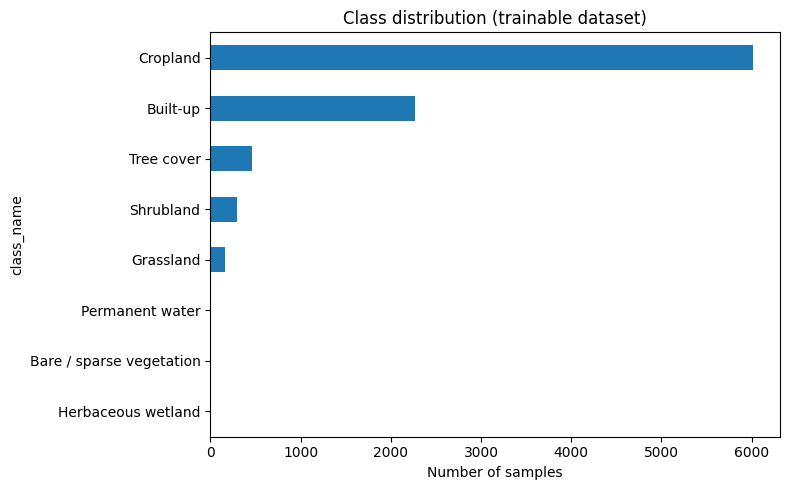

Saved: /content/drive/MyDrive/earth-observation-iitgn-2025/outputs/class_distribution.png


In [ ]:
plt.figure(figsize=(8,5))
counts = df_trainable['class_name'].value_counts().sort_values(ascending=True)
counts.plot(kind='barh')
plt.title("Class distribution (trainable dataset)")
plt.xlabel("Number of samples")
plt.tight_layout()
plt.savefig(OUTPUTS / "class_distribution.png", dpi=200)
plt.show()
print("Saved:", OUTPUTS / "class_distribution.png")


**senario -1 : Q3**

In [ ]:
import os
from pathlib import Path
import pandas as pd
import numpy as np
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torchvision import transforms, models
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
import torchmetrics
import json

BASE = Path("/content/drive/MyDrive/earth-observation-iitgn-2025")
DATA_DIR = BASE / "data"
OUTPUTS = BASE / "outputs"
RGB_DIR = DATA_DIR / "rgb"

train_csv = OUTPUTS / "train_split.csv"
test_csv  = OUTPUTS / "test_split.csv"
labels_csv = OUTPUTS / "landcover_labeled_dataset.csv"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)


Device: cuda


In [ ]:
# Build mapping from class_name values present in your train file
train_df = pd.read_csv(train_csv)
test_df  = pd.read_csv(test_csv)

classes = sorted(train_df['class_name'].unique().tolist())
class2idx = {c:i for i,c in enumerate(classes)}
idx2class = {i:c for c,i in class2idx.items()}
print("Classes:", classes)
print("Class counts (train):")
print(train_df['class_name'].value_counts())


Classes: ['Bare / sparse vegetation', 'Built-up', 'Cropland', 'Grassland', 'Herbaceous wetland', 'Permanent water', 'Shrubland', 'Tree cover']
Class counts (train):
class_name
Cropland                    3608
Built-up                    1358
Tree cover                   280
Shrubland                    178
Grassland                     98
Permanent water                4
Bare / sparse vegetation       2
Herbaceous wetland             1
Name: count, dtype: int64


In [ ]:
class SentinelDataset(Dataset):
    def __init__(self, df, rgb_root, class2idx, transform=None):
        self.df = df.reset_index(drop=True)
        self.rgb_root = Path(rgb_root)
        self.class2idx = class2idx
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        fname = row['filename']
        img_path = self.rgb_root / fname
        img = Image.open(img_path).convert("RGB")
        if self.transform:
            img = self.transform(img)
        label_name = row['class_name']
        label = self.class2idx[label_name]
        return img, label, fname


In [ ]:
BATCH_SIZE = 32
IMG_SIZE = 224  # ResNet standard

train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE,IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
])
val_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE,IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
])

train_ds = SentinelDataset(train_df, RGB_DIR, class2idx, transform=train_transform)
test_ds  = SentinelDataset(test_df,  RGB_DIR, class2idx, transform=val_transform)

# Weighted sampler to reduce influence of majority classes
class_counts = train_df['class_name'].map(class2idx).value_counts().sort_index().values
class_counts = class_counts.astype(float)
weights_per_class = 1.0 / (class_counts + 1e-8)
sample_weights = [weights_per_class[class2idx[name]] for name in train_df['class_name'].tolist()]
sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, sampler=sampler, num_workers=2, pin_memory=True)
val_loader   = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)


In [ ]:
num_classes = len(classes)
model = models.resnet18(pretrained=True)
# replace final layer
model.fc = nn.Linear(model.fc.in_features, num_classes)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 143MB/s]


In [ ]:
EPOCHS = 10
best_val_f1 = 0.0
history = {"train_loss":[], "val_loss":[], "val_macro_f1":[]}

for epoch in range(1, EPOCHS+1):
    model.train()
    running_loss = 0.0
    for imgs, labels, _ in train_loader:
        imgs = imgs.to(device); labels = labels.to(device)
        optimizer.zero_grad()
        out = model(imgs)
        loss = criterion(out, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * imgs.size(0)
    train_loss = running_loss / len(train_loader.sampler)
    scheduler.step()

    # validation
    model.eval()
    all_preds = []
    all_labels = []
    val_loss = 0.0
    with torch.no_grad():
        for imgs, labels, _ in val_loader:
            imgs = imgs.to(device); labels = labels.to(device)
            out = model(imgs)
            loss = criterion(out, labels)
            val_loss += loss.item() * imgs.size(0)
            preds = torch.argmax(out, dim=1)
            all_preds.append(preds.cpu().numpy())
            all_labels.append(labels.cpu().numpy())
    val_loss = val_loss / len(test_ds)
    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)

    # custom compute macro F1 per epoch (use sklearn)
    p, r, f1, _ = precision_recall_fscore_support(all_labels, all_preds, labels=list(range(num_classes)), average=None, zero_division=0)
    macro_f1 = np.mean(f1)

    history["train_loss"].append(train_loss)
    history["val_loss"].append(val_loss)
    history["val_macro_f1"].append(macro_f1)

    print(f"Epoch {epoch}/{EPOCHS} — train_loss: {train_loss:.4f}  val_loss: {val_loss:.4f}  val_macro_f1: {macro_f1:.4f}")

    # Save best
    if macro_f1 > best_val_f1:
        best_val_f1 = macro_f1
        torch.save(model.state_dict(), str(OUTPUTS / "best_resnet18.pth"))
        print("Saved best model (macro_f1 improved).")


Epoch 1/10 — train_loss: 0.7861  val_loss: 1.0740  val_macro_f1: 0.3567
Saved best model (macro_f1 improved).
Epoch 2/10 — train_loss: 0.4552  val_loss: 1.0416  val_macro_f1: 0.4104
Saved best model (macro_f1 improved).
Epoch 3/10 — train_loss: 0.3151  val_loss: 1.2406  val_macro_f1: 0.5526
Saved best model (macro_f1 improved).
Epoch 4/10 — train_loss: 0.2337  val_loss: 1.1904  val_macro_f1: 0.5487
Epoch 5/10 — train_loss: 0.2158  val_loss: 0.9138  val_macro_f1: 0.5250
Epoch 6/10 — train_loss: 0.1704  val_loss: 0.8902  val_macro_f1: 0.6070
Saved best model (macro_f1 improved).
Epoch 7/10 — train_loss: 0.1227  val_loss: 0.8809  val_macro_f1: 0.4914
Epoch 8/10 — train_loss: 0.1096  val_loss: 0.9300  val_macro_f1: 0.4800
Epoch 9/10 — train_loss: 0.1017  val_loss: 0.8909  val_macro_f1: 0.5004
Epoch 10/10 — train_loss: 0.1029  val_loss: 0.9897  val_macro_f1: 0.6140
Saved best model (macro_f1 improved).


In [ ]:
# load best
model.load_state_dict(torch.load(str(OUTPUTS / "best_resnet18.pth"), map_location=device))
model.eval()

all_preds = []
all_labels = []
all_fnames = []
with torch.no_grad():
    for imgs, labels, fnames in val_loader:
        imgs = imgs.to(device)
        out = model(imgs)
        preds = torch.argmax(out, dim=1).cpu().numpy()
        all_preds.append(preds)
        all_labels.append(labels.numpy())
        all_fnames.extend(fnames)
all_preds = np.concatenate(all_preds)
all_labels = np.concatenate(all_labels)

# confusion matrix
cm = confusion_matrix(all_labels, all_preds, labels=list(range(num_classes)))
np.save(OUTPUTS / "confusion_matrix.npy", cm)
print("Confusion matrix saved.")

# per-class metrics (precision, recall, f1)
prec, rec, f1, sup = precision_recall_fscore_support(all_labels, all_preds, labels=list(range(num_classes)), zero_division=0)
results = []
for i in range(num_classes):
    tn = cm.sum() - (cm[i,:].sum() + cm[:,i].sum() - cm[i,i])
    fp = cm[:,i].sum() - cm[i,i]
    fn = cm[i,:].sum() - cm[i,i]
    specificity = tn / (tn + fp) if (tn+fp)>0 else 0.0
    sensitivity = rec[i]  # same as recall
    results.append({
        "class": idx2class[i],
        "precision": float(prec[i]),
        "recall": float(rec[i]),
        "f1": float(f1[i]),
        "support": int(sup[i]),
        "sensitivity": float(sensitivity),
        "specificity": float(specificity)
    })

# Save metrics json
with open(OUTPUTS / "per_class_metrics.json", "w") as f:
    json.dump(results, f, indent=2)

print("Per-class metrics saved to per_class_metrics.json")
for r in results:
    print(r["class"], "prec", round(r["precision"],3), "rec", round(r["recall"],3), "f1", round(r["f1"],3), "spec", round(r["specificity"],3))


Confusion matrix saved.
Per-class metrics saved to per_class_metrics.json
Bare / sparse vegetation prec 1.0 rec 1.0 f1 1.0 spec 1.0
Built-up prec 0.475 rec 0.638 f1 0.545 spec 0.77
Cropland prec 0.824 rec 0.755 f1 0.788 spec 0.698
Grassland prec 0.375 rec 0.138 f1 0.202 spec 0.996
Herbaceous wetland prec 1.0 rec 1.0 f1 1.0 spec 1.0
Permanent water prec 1.0 rec 0.333 f1 0.5 spec 1.0
Shrubland prec 0.441 rec 0.534 f1 0.483 spec 0.978
Tree cover prec 0.577 rec 0.299 f1 0.394 spec 0.988


In [ ]:
from torchmetrics.classification import F1Score

# For multi-class classification
f1_metric = F1Score(task="multiclass", num_classes=num_classes, average="macro").to(device)

f1_metric.reset()

with torch.no_grad():
    for imgs, labels, _ in val_loader:
        imgs = imgs.to(device)
        labels = labels.to(device)
        preds = model(imgs)
        preds_label = torch.argmax(preds, dim=1)
        f1_metric.update(preds_label, labels)

torchmetrics_macro_f1 = f1_metric.compute().item()

print("TorchMetrics macro F1:", torchmetrics_macro_f1)
print("Custom macro F1:", np.mean([r['f1'] for r in results]))


TorchMetrics macro F1: 0.6139885187149048
Custom macro F1: 0.6139884904543933


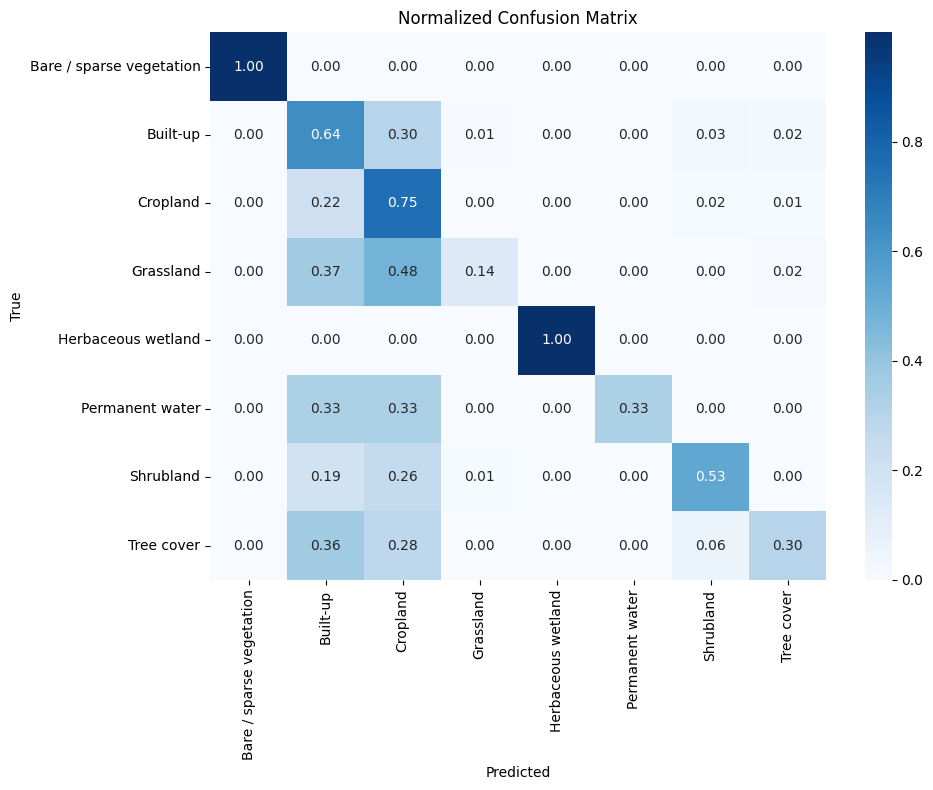

In [ ]:
import seaborn as sns
plt.figure(figsize=(10,8))
cm_norm = cm.astype('float') / (cm.sum(axis=1)[:, np.newaxis] + 1e-8)
sns.heatmap(cm_norm, xticklabels=[idx2class[i] for i in range(num_classes)],
            yticklabels=[idx2class[i] for i in range(num_classes)], annot=True, fmt=".2f", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Normalized Confusion Matrix")
plt.tight_layout()
plt.savefig(OUTPUTS / "confusion_matrix_norm.png", dpi=200)
plt.show()


In [ ]:
# collect indices of correct/incorrect
correct_idx = np.where(all_preds == all_labels)[0]
incorrect_idx = np.where(all_preds != all_labels)[0]

# helper to plot and save sample
def save_examples(idx_list, kind, n=5):
    os.makedirs(OUTPUTS / f"samples_{kind}", exist_ok=True)
    sel = idx_list[:n]
    for i, idx in enumerate(sel):
        fname = all_fnames[idx]
        pred = idx2class[all_preds[idx]]
        true = idx2class[all_labels[idx]]
        img = Image.open(RGB_DIR / fname).convert("RGB")
        fig, ax = plt.subplots(figsize=(3,3))
        ax.imshow(img)
        ax.set_title(f"{true} → {pred}")
        ax.axis('off')
        outp = OUTPUTS / f"samples_{kind}" / f"{i}_{fname.replace('/','_')}.png"
        fig.savefig(outp, bbox_inches="tight")
        plt.close(fig)
    print(f"Saved {len(sel)} {kind} examples to", OUTPUTS / f"samples_{kind}")

save_examples(correct_idx, "correct", n=5)
save_examples(incorrect_idx, "incorrect", n=5)


Saved 5 correct examples to /content/drive/MyDrive/earth-observation-iitgn-2025/outputs/samples_correct
Saved 5 incorrect examples to /content/drive/MyDrive/earth-observation-iitgn-2025/outputs/samples_incorrect
